In [1]:
import sys

sys.path.append('../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

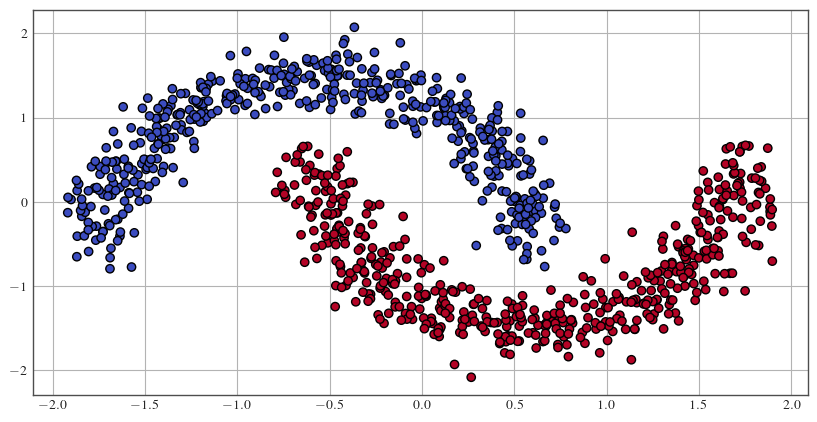

In [2]:
from sklearn import datasets
X, y = datasets.make_moons(1000, noise=.1)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
from models.spectral_norm import spectral_norm_fc

class Net(nn.Module):
    def __init__(self, n_residual_layers=4, feature_dim=128, spectral_norm=True, coeff=1, n_power_iterations=1):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.residuals = nn.ModuleList(
            [nn.Linear(feature_dim, feature_dim) for i in range(n_residual_layers)])
        self.last = nn.Linear(feature_dim, 2)

        # Add spectral norm
        if spectral_norm:
            for residual in self.residuals:
                spectral_norm_fc(
                    residual,
                    coeff=coeff,
                    n_power_iterations=n_power_iterations
                )

        self.act = nn.ELU()

    def forward(self, x, return_features=False):
        # : Added activation to first layer
        x = self.act(self.first(x))
        for residual in self.residuals:
            x = self.act(residual(x)) + x
        features = x
        x = self.last(x)
        if return_features:
            return x, features
        return x

In [4]:
from models.sngp import SNGP, scale_logits
from utils import MetricLogger
from metrics import generalization

def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch=None, print_freq=1000):
    model.train()
    model.reset_covariance()
    model.to(device)

    metric_logger = MetricLogger(delimiter=" ")
    header = f"Epoch [{epoch}]" if epoch is not None else "  Train: "

    # Train the epoch
    for inputs, targets in metric_logger.log_every(dataloader, print_freq, header):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_size = inputs.shape[0]
        acc1, = generalization.accuracy(outputs, targets, topk=(1,))
        metric_logger.update(loss=loss.item())
        metric_logger.meters["acc1"].update(acc1.item(), n=batch_size)

    train_stats = {f"train_{k}": meter.global_avg for k, meter, in metric_logger.meters.items()}
    return train_stats

  Train:  [ 0/16] eta: 0:00:00 loss: 0.8140 (0.8140) acc1: 53.1250 (53.1250) time: 0.0067 data: 0.0009 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.8672 (0.8672) acc1: 56.2500 (56.2500) time: 0.0043 data: 0.0004 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 1.1561 (1.1561) acc1: 42.1875 (42.1875) time: 0.0044 data: 0.0004 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.8317 (0.8317) acc1: 50.0000 (50.0000) time: 0.0046 data: 0.0004 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 1.0476 (1.0476) acc1: 42.1875 (42.1875) time: 0.0042 data: 0.0004 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.9822 (0.9822) acc1: 45.3125 (45.3125) time: 0.0043 data: 0.0004 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.7969 (0.7969) acc1: 54.6875 (54.6875) time: 0.0041 data: 0.0004 max mem: 0
  Train:  Total time: 

/tmp/ipykernel_1536/4125899678.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


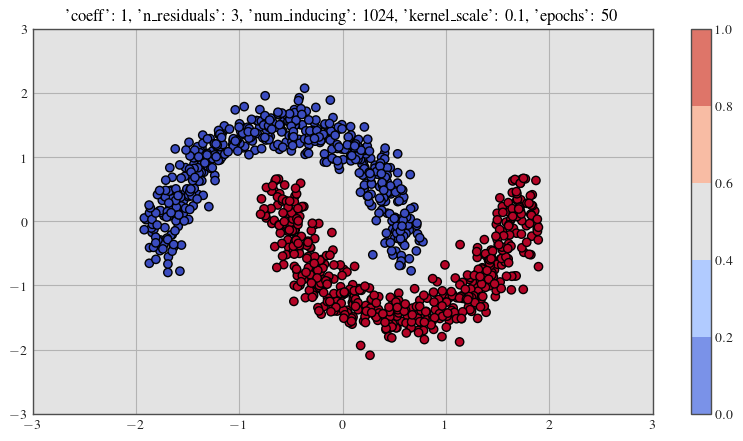

  Train:  [ 0/16] eta: 0:00:00 loss: 0.7341 (0.7341) acc1: 50.0000 (50.0000) time: 0.0057 data: 0.0007 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.1103 (0.1103) acc1: 98.4375 (98.4375) time: 0.0049 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0291 (0.0291) acc1: 100.0000 (100.0000) time: 0.0047 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0139 (0.0139) acc1: 100.0000 (100.0000) time: 0.0048 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0083 (0.0083) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0052 (0.0052) acc1: 100.0000 (100.0000) time: 0.0050 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0055 (0.0055) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0005 max mem: 0
  Train:  To

/tmp/ipykernel_1536/4125899678.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


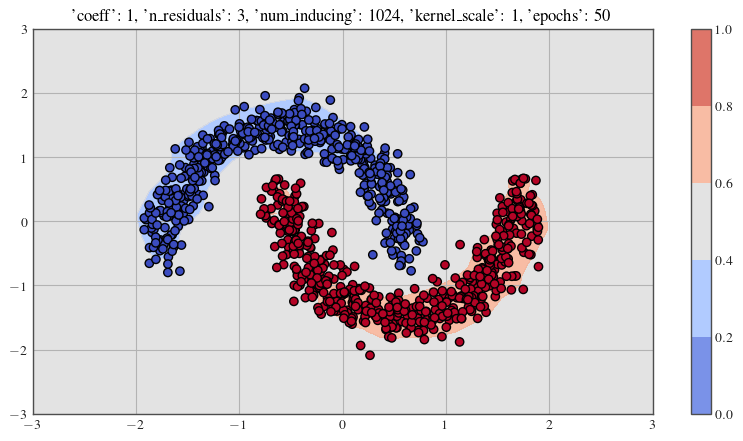

  Train:  [ 0/16] eta: 0:00:00 loss: 0.7250 (0.7250) acc1: 53.1250 (53.1250) time: 0.0061 data: 0.0007 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0229 (0.0229) acc1: 100.0000 (100.0000) time: 0.0047 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0038 (0.0038) acc1: 100.0000 (100.0000) time: 0.0047 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0027 (0.0027) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0011 (0.0011) acc1: 100.0000 (100.0000) time: 0.0046 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0073 (0.0073) acc1: 100.0000 (100.0000) time: 0.0046 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0010 (0.0010) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0005 max mem: 0
  Train:  

/tmp/ipykernel_1536/4125899678.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


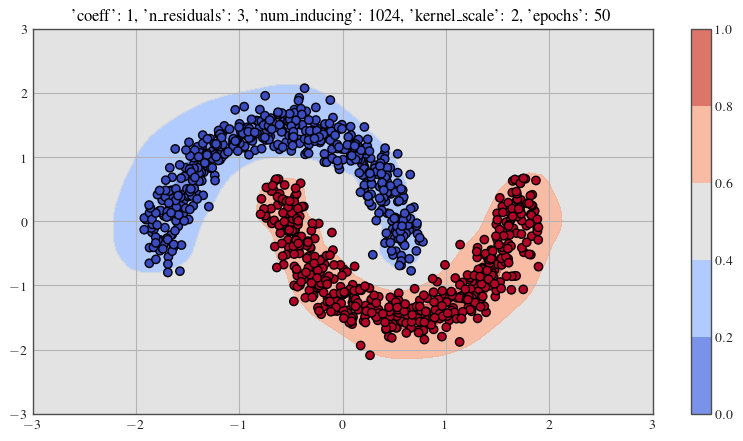

  Train:  [ 0/16] eta: 0:00:00 loss: 0.3851 (0.3851) acc1: 78.1250 (78.1250) time: 0.0056 data: 0.0006 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0198 (0.0198) acc1: 100.0000 (100.0000) time: 0.0045 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0031 (0.0031) acc1: 100.0000 (100.0000) time: 0.0042 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0089 (0.0089) acc1: 100.0000 (100.0000) time: 0.0047 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0016 (0.0016) acc1: 100.0000 (100.0000) time: 0.0048 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0019 (0.0019) acc1: 100.0000 (100.0000) time: 0.0046 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0014 (0.0014) acc1: 100.0000 (100.0000) time: 0.0046 data: 0.0005 max mem: 0
  Train:  

/tmp/ipykernel_1536/4125899678.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


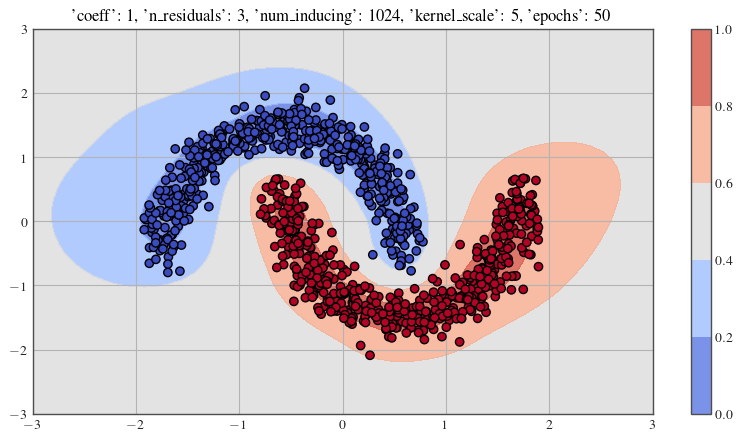

  Train:  [ 0/16] eta: 0:00:00 loss: 0.6376 (0.6376) acc1: 79.6875 (79.6875) time: 0.0056 data: 0.0006 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0771 (0.0771) acc1: 96.8750 (96.8750) time: 0.0044 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0261 (0.0261) acc1: 100.0000 (100.0000) time: 0.0042 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0171 (0.0171) acc1: 100.0000 (100.0000) time: 0.0047 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0084 (0.0084) acc1: 100.0000 (100.0000) time: 0.0043 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0040 (0.0040) acc1: 100.0000 (100.0000) time: 0.0042 data: 0.0005 max mem: 0
  Train:  Total time: 0:00:00
  Train:  [ 0/16] eta: 0:00:00 loss: 0.0038 (0.0038) acc1: 100.0000 (100.0000) time: 0.0044 data: 0.0005 max mem: 0
  Train:  To

/tmp/ipykernel_1536/4125899678.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


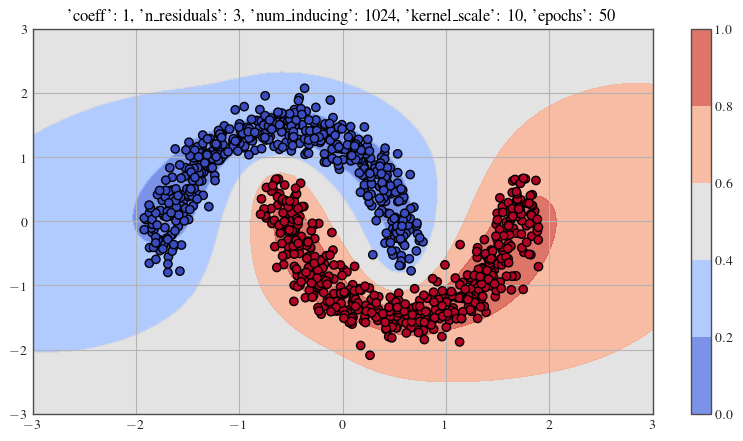

In [11]:

def train_sngp_and_visualize(hparams):
    model = SNGP(
        model=Net(coeff=hparams['coeff'], n_residual_layers=hparams['n_residuals']),
        in_features=128,
        num_classes=2,
        num_inducing=hparams['num_inducing'],
        kernel_scale=hparams['kernel_scale'],
        momentum=.999,
    )
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    for i in range(hparams['epochs']):
        train_one_epoch(model, train_loader, criterion, optimizer, device='cpu')

    model.eval()
    xx, yy = torch.meshgrid(torch.linspace(-3, 3, 51), torch.linspace(-3, 3, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)
    with torch.no_grad():
        logits, cov = model(zz, return_cov=True, update_precision=False)

    # mean field approx
    logits = scale_logits(logits, cov)
    probas = logits.softmax(-1)

    plt.title(hparams)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.contourf(xx, yy, probas[:, 1].view(xx.shape), alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()
    plt.show()

for var in [.1, 1, 2, 5, 10]:
    hparams = {
        'coeff': 1,
        'n_residuals': 3,
        'num_inducing': 1024,
        'kernel_scale': var,
        'epochs': 50,
    }
    train_sngp_and_visualize(hparams)